**Problem Statement:**

The goal of this project is to forecast energy consumption in smart homes using AI/ML models and detect anomalies such as faulty appliances, energy leakage, or unusual consumption patterns.


Objectives:
1. Predict hourly/daily energy consumption for a household.
2. Detect anomalies in energy usage for appliances or entire household.
3. Prepare outputs for voice assistant integration.
4. Future scope: integrate with automation tools like n8n to trigger smart home actions.

In [1]:
# Data manipulation & numerical operations
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & scaling
from sklearn.preprocessing import StandardScaler

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Anomaly detection
from sklearn.ensemble import IsolationForest

# Saving/loading models
import joblib

# For handling datetime features
from datetime import datetime


In [4]:
from google.colab import files

uploaded = files.upload()  # This will open a file chooser in Colab


Saving individual+household+electric+power+consumption.zip to individual+household+electric+power+consumption.zip


### Datasets:

1. **Household Power Consumption Dataset (UCI)**
   - Contains 1-minute interval readings for a single household.
   - Features: Global_active_power, Global_reactive_power, Voltage, Sub-metering for appliances.

2. **Optional Weather Data**
   - Source: OpenWeatherMap API or NOAA
   - Features: Temperature, Humidity, Solar radiation (for better forecasting)

### Understanding the Data:
- Visualize energy consumption trends (daily/hourly).
- Check missing values, outliers, and patterns.
- Identify peak usage times and unusual spikes for anomaly detection.


In [10]:
import pandas as pd

# If the dataset is a zip file, pandas can read it directly
df = pd.read_csv('household_power_consumption.csv.zip',
                 sep=';',
                 low_memory=False)

# Combine Date and Time into a datetime column safely
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Drop the original Date and Time columns
df.drop(columns=['Date','Time'], inplace=True)

# Replace missing values safely
df.replace('?', pd.NA, inplace=True)
df.ffill(inplace=True)  # forward-fill missing values

# Convert numeric columns to float
numeric_cols = ['Global_active_power','Global_reactive_power','Voltage',
                'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']

df[numeric_cols] = df[numeric_cols].astype(float)

print(df.head())
print(df.info())
print(df.describe())


   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            datetime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):

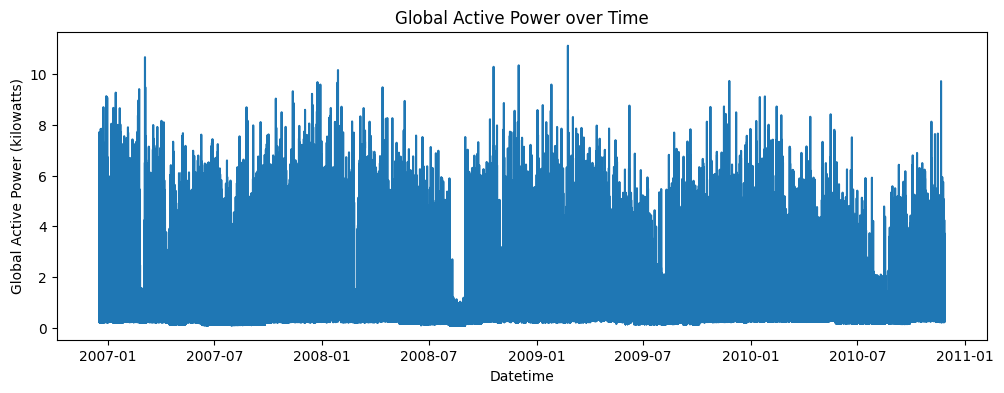

In [11]:
# Visualize Global Active Power over time
plt.figure(figsize=(12,4))
plt.plot(df['datetime'], df['Global_active_power'].astype(float))
plt.title('Global Active Power over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()


**Data Preprocessing**
### Steps:
1. Convert relevant columns to float
2. Feature Engineering: extract hour, day, weekday
3. Scaling using StandardScaler
4. Prepare outputs for anomaly detection and voice assistant



In [12]:
# Feature engineering
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

# Convert to float
df['Global_active_power'] = df['Global_active_power'].astype(float)
df['Global_reactive_power'] = df['Global_reactive_power'].astype(float)
df['Voltage'] = df['Voltage'].astype(float)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Global_active_power','Global_reactive_power','Voltage']])

df_scaled = pd.DataFrame(scaled_features, columns=['Global_active_power','Global_reactive_power','Voltage'])
df_scaled['hour'] = df['hour']
df_scaled['day'] = df['day']
df_scaled['weekday'] = df['weekday']

df_scaled.head()


,Global_active_power,Global_reactive_power,Voltage,hour,day,weekday
0,2.971815,2.618973,-1.854882,17,16,5
1,4.058057,2.778952,-2.228850,17,16,5
2,4.071350,3.329993,-2.333932,17,16,5
3,4.084643,3.365544,-2.194853,17,16,5
4,2.449583,3.596626,-1.595268,17,16,5


**Anomaly Detection**
### Detect unusual energy usage patterns
- Using Isolation Forest for anomaly detection


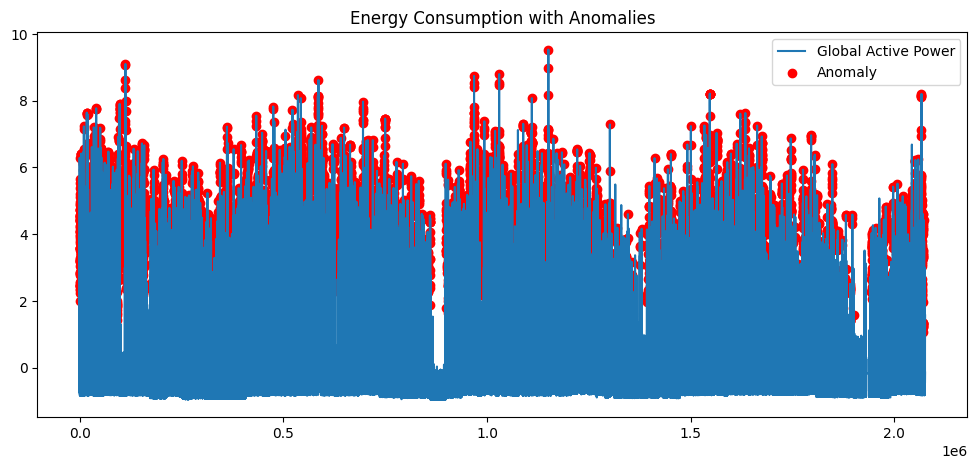

In [13]:
# Using Isolation Forest to detect anomalies
iso = IsolationForest(contamination=0.01, random_state=42)
df_scaled['anomaly'] = iso.fit_predict(df_scaled[['Global_active_power','Global_reactive_power','Voltage']])

# Visualize anomalies
plt.figure(figsize=(12,5))
plt.plot(df_scaled['Global_active_power'], label='Global Active Power')
plt.scatter(df_scaled.index[df_scaled['anomaly']==-1],
            df_scaled['Global_active_power'][df_scaled['anomaly']==-1],
            color='red', label='Anomaly')
plt.title('Energy Consumption with Anomalies')
plt.legend()
plt.show()


**Data Splitting**
### Split data for model training
- 70% training, 15% validation, 15% testing


In [14]:
X = df_scaled[['Global_reactive_power','Voltage','hour','day','weekday']]
y = df_scaled['Global_active_power']

# Chronological split
train_size = int(len(X)*0.7)
val_size = int(len(X)*0.15)
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 1452681
Validation size: 311288
Test size: 311290
